In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns



0       0.12605
1       0.11765
2       0.20560
3       0.17385
4       0.17435
         ...   
1043    0.23500
1044    0.16580
1045    0.22910
1046    0.19870
1047    0.26405
Name: dmb, Length: 1048, dtype: float64
0       0.126758
1       0.118172
2       0.206020
3       0.174903
4       0.175347
          ...   
1043    0.240455
1044    0.167341
1045    0.230717
1046    0.205158
1047    0.266223
Name: dmb, Length: 1048, dtype: float64


array([ 2.26      , 26.877     ,  0.45106897])

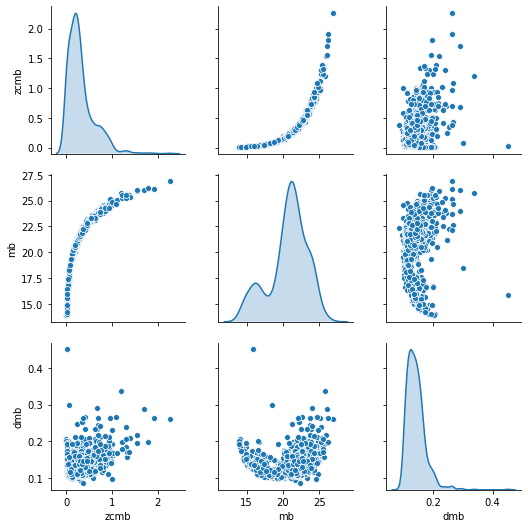

In [3]:
file = 'data/pantheon.txt'
data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'])
print(data['dmb'])
syscov = np.loadtxt('data/pantheon_errors.txt',skiprows=1).reshape((1048,1048))
diag = np.diag(syscov)
data['dmb'] = np.sqrt(diag + data['dmb']**2)
print(data['dmb'])
sns.pairplot(data, diag_kind="kde")
plt.savefig("distSNPantheon.png")
data = np.sort(data.values, axis=0)
data[1047, :]


In [4]:
# randomize = np.random.permutation(len(data.values))
# randomize
shuffle = [x for x in range(len(data)) if x%2==1]
even = [x for x in range(len(data)) if x%2==0]
shuffle.extend(even)
np.max(shuffle)

1047

Let's prepare our input data. 

In [5]:
print(data[1047, 0])
data = data[shuffle]

2.26


In [6]:
X = data[:, 0]
y = data[:, 1:]
X.shape, y.shape

((1048,), (1048, 2))

In [7]:
split = 0.8
ntrain = int(split * len(X))
indx = [ntrain]
X_train, X_test = np.split(X, indx)
y_train, y_test = np.split(y, indx)

In [8]:
# scaler = StandardScaler()
# # scaler = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scaler.fit(X.reshape(-1,1))
# # apply transform
# X = scaler.transform(X.reshape(-1,1))
# # X

In [9]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden2 = Dense(100, activation='relu')(efirst)
    ehidden3 = Dense(100, activation='relu')(ehidden2)
    elast = Dense(2, activation='linear')(ehidden3)
       
    return elast

In [10]:
batch_size = 32
epochs = 300
input_z = Input(shape = (1,))

In [11]:
snmodel = Model(input_z, model(input_z))
snmodel.compile(loss='mean_squared_error', optimizer = 'adam')

In [12]:
snmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 20,602
Trainable params: 20,602
Non-trainable params: 0
_________________________________________________________________


In [13]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=10,
                                   restore_best_weights=True)]

In [14]:
snmodel_train = snmodel.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1, 
                            validation_data=(X_test, y_test))

Epoch 1/300
27/27 [==============================] - 0s 5ms/step - loss: 195.5470 - val_loss: 211.0190
Epoch 2/300
27/27 [==============================] - 0s 1ms/step - loss: 123.4618 - val_loss: 31.9051
Epoch 3/300
27/27 [==============================] - 0s 2ms/step - loss: 18.8062 - val_loss: 38.6520
Epoch 4/300
27/27 [==============================] - 0s 1ms/step - loss: 9.1016 - val_loss: 14.9718
Epoch 5/300
27/27 [==============================] - 0s 1ms/step - loss: 6.3229 - val_loss: 12.5027
Epoch 6/300
27/27 [==============================] - 0s 2ms/step - loss: 4.4378 - val_loss: 8.8170
Epoch 7/300
27/27 [==============================] - 0s 1ms/step - loss: 3.2143 - val_loss: 6.7921
Epoch 8/300
27/27 [==============================] - 0s 2ms/step - loss: 2.3625 - val_loss: 5.5417
Epoch 9/300
27/27 [==============================] - 0s 2ms/step - loss: 1.7404 - val_loss: 3.1245
Epoch 10/300
27/27 [==============================] - 0s 2ms/step - loss: 1.2872 - val_loss: 2.396

Epoch 83/300
27/27 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0168
Epoch 84/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0730 - val_loss: 0.0149
Epoch 85/300
27/27 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0446
Epoch 86/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0117
Epoch 87/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0074
Epoch 88/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0115
Epoch 89/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0113
Epoch 90/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0138
Epoch 91/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0055
Epoch 92/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0108


27/27 [==============================] - 0s 1ms/step - loss: 0.0217 - val_loss: 0.0063
Epoch 165/300
27/27 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0079
Epoch 166/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0220 - val_loss: 0.0049
Epoch 167/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0223 - val_loss: 0.0239
Epoch 168/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0245 - val_loss: 0.0131
Epoch 169/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0210 - val_loss: 0.0117
Epoch 170/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0283
Epoch 171/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0160
Epoch 172/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0720
Epoch 173/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0540 - val_loss: 0.0269
Epoc

27/27 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0094
Epoch 246/300
27/27 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0036
Epoch 247/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0196 - val_loss: 0.0494
Epoch 248/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.1874
Epoch 249/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0179
Epoch 250/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0132 - val_loss: 0.0035
Epoch 251/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0418
Epoch 252/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0140 - val_loss: 0.0026
Epoch 253/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0078
Epoch 254/300
27/27 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0745
Epoc

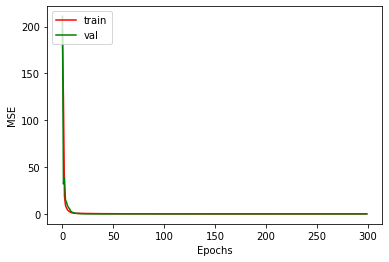

In [15]:
plt.plot(snmodel_train.history['loss'], color='r', )
plt.plot(snmodel_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_sn.png", dpi=200)

In [16]:
pred = snmodel.predict(X_test)
pred.shape

(210, 2)

In [17]:
pred

array([[21.618303  ,  0.14760916],
       [21.626852  ,  0.1477118 ],
       [21.630434  ,  0.14775424],
       [21.639555  ,  0.14786308],
       [21.64776   ,  0.14796136],
       [21.662659  ,  0.14813946],
       [21.67121   ,  0.14824109],
       [21.68923   ,  0.14845668],
       [21.691423  ,  0.14848308],
       [21.700779  ,  0.14859478],
       [21.718103  ,  0.14880149],
       [21.731966  ,  0.14896761],
       [21.734045  ,  0.14899246],
       [21.748716  ,  0.14916722],
       [21.774475  ,  0.14947526],
       [21.795267  ,  0.14972346],
       [21.798267  ,  0.14975952],
       [21.808435  ,  0.14988093],
       [21.824919  ,  0.15008156],
       [21.828676  ,  0.15012752],
       [21.835382  ,  0.15020953],
       [21.839409  ,  0.1502584 ],
       [21.855291  ,  0.15045296],
       [21.861942  ,  0.1505342 ],
       [21.867308  ,  0.15059988],
       [21.8775    ,  0.15072505],
       [21.880188  ,  0.15075777],
       [21.885015  ,  0.15081678],
       [21.887697  ,

In [18]:
r = np.random.uniform(0, 2.3, size=10000)
# rr = scaler.transform(r.reshape(-1,1))
# X = scaler.inverse_transform(X)
# X
print(np.max(X), len(X), X[1047])

2.26 1048 1.9140000000000001


In [19]:
pred_random = snmodel.predict(r)
# pred_random

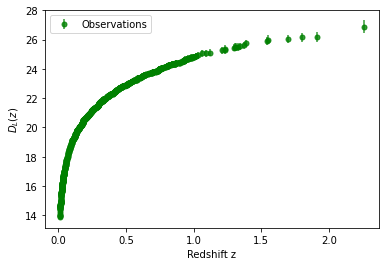

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(X, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
# plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r*', markersize=3, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
# ax.set_xscale('log')

# plt.xlim(np.min(X), 2.4)
plt.legend()
# plt.savefig("syntheticSN.png", dpi=300)

In [21]:
# Cosmological constants
Om = 0.27

In [22]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

In [23]:
# z = np.linspace(0, 2.2, 1000)
# # plt.scatter(data[:, 0], data[:, 1], c='g')
# yupp = pred_random[:,0]+pred_random[:,1]
# ylow = pred_random[:,0]-pred_random[:,1]
# plt.errorbar(X, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=1, label='Synthetic data with errors', alpha=0.01, )
# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=64.4), label='$\Lambda CDM$ $H_0 = 64.4$', c='b')
# plt.xlabel("Redshift z")
# plt.ylabel("$H(z)$")
# plt.xlim(0,2.2)
# plt.legend()

# plt.savefig("SyntheticHD.png",dpi=800)

In [24]:
# pred_random.shape, r.shape

In [50]:
# rr = np.random.uniform(0, 2.3, size=500)
rr = np.linspace(0, 2.3, num=500)
print(len(rr))
pred_random = snmodel.predict(rr)
mookSN = np.concatenate((rr.reshape(-1,1), pred_random), axis=1)
np.savetxt("neuralSN.dat",mookSN, delimiter=" ")

500


In [51]:
rr

array([0.        , 0.00460922, 0.00921844, 0.01382766, 0.01843687,
       0.02304609, 0.02765531, 0.03226453, 0.03687375, 0.04148297,
       0.04609218, 0.0507014 , 0.05531062, 0.05991984, 0.06452906,
       0.06913828, 0.07374749, 0.07835671, 0.08296593, 0.08757515,
       0.09218437, 0.09679359, 0.10140281, 0.10601202, 0.11062124,
       0.11523046, 0.11983968, 0.1244489 , 0.12905812, 0.13366733,
       0.13827655, 0.14288577, 0.14749499, 0.15210421, 0.15671343,
       0.16132265, 0.16593186, 0.17054108, 0.1751503 , 0.17975952,
       0.18436874, 0.18897796, 0.19358717, 0.19819639, 0.20280561,
       0.20741483, 0.21202405, 0.21663327, 0.22124248, 0.2258517 ,
       0.23046092, 0.23507014, 0.23967936, 0.24428858, 0.2488978 ,
       0.25350701, 0.25811623, 0.26272545, 0.26733467, 0.27194389,
       0.27655311, 0.28116232, 0.28577154, 0.29038076, 0.29498998,
       0.2995992 , 0.30420842, 0.30881764, 0.31342685, 0.31803607,
       0.32264529, 0.32725451, 0.33186373, 0.33647295, 0.34108